In [1]:
import numpy as np
import pandas as pd
import patsy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, roc_auc_score

## Final Practice Problem

Write code to build features for this problem. A simple representation such as bag of words should work but feel free to make it more interesting.

1. Create a pandas dataframe for your data.
2. Divide the data into 80% training and 20% validation.
3. What is the loss function that you would use for this problem? Why?
4. Create a linear model  and report training and validation accuracy.
5. Create a Random Forest and report training and validation accuracy.
6. What are the hyper-parameters of a these model and how would you go about finding the optimal values? Please produce some plots showing range of hyperparameter(s) vs loss.


In [2]:
df = pd.read_csv('./train.csv')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


## Important! Check to see the initial proportion

It's important to note that we need to be better than ~64% accuracy for improvement

In [3]:
print(df['is_duplicate'].value_counts())
print(df['is_duplicate'].mean())

0    255027
1    149263
Name: is_duplicate, dtype: int64
0.369197853026


### Feature Engineering

#### Cleaning up the data, and splitting up questions by words

In [4]:
%%time
import re

# get rid of punctuation
mask = re.compile('[^a-zA-Z0-9 ]')
df = pd.read_csv('./train.csv')

df['question1'].fillna('',inplace=True)
df['question2'].fillna('',inplace=True)

df['question1'] = df['question1'].map(lambda x : re.sub(mask,' ', x))
df['question2'] = df['question2'].map(lambda x : re.sub(mask,' ', x))

def split_punc(x):
    orig = x
    sents = [x]
    if '.' in orig:
        sents.extend([z for y in sents for z in y.split('.')])
    elif '?' in orig:
        sents.extend([z for y in sents for z in y.split('?')])
    elif '!' in orig:
        sents.extend([z for y in sents for z in y.split('!')])
        
    return sents

df['q1_words'] = df['question1'].map(lambda x : set(x.lower().split(' ')))
df['q2_words'] = df['question2'].map(lambda x : set(x.lower().split(' ')))
df.head()
#df['q1_words'] = df['question1'].map(lambda x : x.split(' '))

CPU times: user 6.4 s, sys: 407 ms, total: 6.8 s
Wall time: 6.81 s


#### Calculating some simple word stats with counting
- length by char of questions
- number of sentences
- number of words
- difference between the two questions in counts

In [5]:
%%time
df['q1_len'] = df['question1'].map(lambda x : len(x))
df['q2_len'] = df['question2'].map(lambda x : len(x))
df['q_len_diff'] = df['q1_len'] - df['q2_len']

df['q1_sent_len'] = df['question1'].map(lambda x : len(split_punc(x)))
df['q2_sent_len'] = df['question2'].map(lambda x : len(split_punc(x)))
df['q_sent_len_diff'] = df['q1_sent_len'] - df['q2_sent_len']


df['q1_word_len'] = df['question1'].map(lambda x : len(x.split(' ')))
df['q2_word_len'] = df['question2'].map(lambda x : len(x.split(' ')))
df['q_word_len_diff'] = df['q1_word_len'] - df['q2_word_len']

def total_unique(set_a, set_b):
    return len(set_a.union(set_b))

def common(set_a, set_b):
    return len(set_a.intersection(set_b))

def different(set_a, set_b):
    return len(set_a.difference(set_b))+len(set_b.difference(set_a))
    
## using set notation
df['unique_ct']  = df.apply(lambda x : total_unique(x['q1_words'],x['q2_words']), axis=1)
df['common_ct'] = df.apply(lambda x : common(x['q1_words'],x['q2_words']), axis=1)
df['difference_ct'] = df.apply(lambda x : different(x['q1_words'],x['q2_words']), axis=1)

CPU times: user 33.5 s, sys: 541 ms, total: 34 s
Wall time: 34 s


### Turning some of our calculated fields into percentages

In [6]:
df['diff_pct'] = df['difference_ct'] / df['unique_ct']
df['common_pct'] = df['common_ct'] / df['unique_ct']
df.head(5).transpose()

,0,1,2,3,4
id,0,1,2,3,4
qid1,1,3,5,7,9
qid2,2,4,6,8,10
question1,What is the step by step guide to invest in sh...,What is the story of Kohinoor Koh i Noor Dia...,How can I increase the speed of my internet co...,Why am I mentally very lonely How can I solve...,Which one dissolve in water quikly sugar salt...
question2,What is the step by step guide to invest in sh...,What would happen if the Indian government sto...,How can Internet speed be increased by hacking...,Find the remainder when math 23 24 math i...,Which fish would survive in salt water
is_duplicate,0,0,0,0,0
q1_words,"{, is, to, invest, the, in, india, share, by, ...","{, is, i, the, noor, koh, of, kohinoor, story,...","{internet, while, , i, speed, connection, the,...","{, very, mentally, i, solve, can, am, lonely, ...","{, quikly, and, water, carbon, dissolve, one, ..."
q2_words,"{, is, to, invest, the, in, share, by, market,...","{, government, i, would, diamond, the, back, n...","{be, internet, , speed, dns, through, can, inc...","{, remainder, is, the, when, 23, 24, math, div...","{, would, survive, water, which, salt, in, fish}"
q1_len,66,51,73,50,76
q2_len,57,88,59,65,39


### Let's see if this enough

In [7]:
y = df['is_duplicate'].values
features =[ x for x in df.columns.values if x not in ['is_duplicate','question1','question2','q1_words','q2_words']]
X = df[features]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

rfc = RandomForestClassifier(criterion='entropy')
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [9]:
rfc.score(X_train,y_train)

0.9858146380073709

In [10]:
rfc.score(X_test,y_test)

0.75960325508916871

### Let's compare the prediction functions
- predictions give 0, 1 for classification
- logprob gives log probabilities
- prob gives the number of classes you have and the probability for each row for class, so a row could be 50/50 or 80/20

In [11]:
y_pred = rfc.predict(X_test)
y_pred

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [12]:
y_logprob = rfc.predict(X_test)
y_logprob

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [13]:
y_prob = rfc.predict_proba(X_test)
y_prob

array([[ 0.7,  0.3],
       [ 0.9,  0.1],
       [ 0.9,  0.1],
       ..., 
       [ 0.4,  0.6],
       [ 0.8,  0.2],
       [ 1. ,  0. ]])

In [14]:
y_results = pd.DataFrame(y_prob)
y_results['logprob'] = y_logprob
y_results['pred'] = y_pred
y_results['actuals'] = y_test

In [15]:
y_results.head(10)

,0,1,logprob,pred,actuals
0,0.7,0.3,0,0,0
1,0.9,0.1,0,0,1
2,0.9,0.1,0,0,0
3,0.8,0.2,0,0,0
4,0.4,0.6,1,1,1
5,0.9,0.1,0,0,0
6,0.3,0.7,1,1,0
7,0.6,0.4,0,0,0
8,1.0,0.0,0,0,0
9,0.9,0.1,0,0,1


### Optimal values vs. loss?

In [16]:
scores = []
for i in range(3,15):
    rfc = RandomForestClassifier(criterion='entropy', n_jobs=-1, n_estimators=i)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    ll = log_loss(y_pred,y_test)
    scores.append((i,ll))


In [17]:
ll_plot = pd.DataFrame(scores)

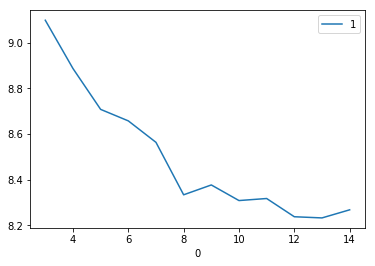

In [18]:
%matplotlib inline
ll_plot.plot(x=0,y=1)